In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


#Imports

In [ ]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

#Dataset splitting

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
      continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)
np.random.shuffle(words_list)

In [ ]:
len(words_list)

96456

we split the dataset into 3 subsets woth a 90:5:5 ratio (train: validation: test)

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
val_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:] # Use val_split_idx to split test_samples

assert len(words_list) == len(train_samples) + len(val_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(val_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


Data Input Pipeline

building our data input pipeline by first preparing the image paths.

In [ ]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(val_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
train_img_paths[0:10]

['data/words/e04/e04-030/e04-030-04-08.png',
 'data/words/k02/k02-102/k02-102-05-03.png',
 'data/words/a01/a01-082u/a01-082u-01-04.png',
 'data/words/m01/m01-000/m01-000-07-00.png',
 'data/words/g01/g01-031/g01-031-07-06.png',
 'data/words/f07/f07-081b/f07-081b-01-06.png',
 'data/words/n03/n03-082/n03-082-04-03.png',
 'data/words/g06/g06-018c/g06-018c-04-05.png',
 'data/words/g06/g06-011j/g06-011j-06-06.png',
 'data/words/f04/f04-024/f04-024-01-06.png']

In [ ]:
train_labels[0:10]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

Then prepare the ground-truth labels.

In [ ]:
#Find the maximum length and the size of the vocabulary in the training data
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))


print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

#checking some label samples
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

cleaning the validation and the test labels as well

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

Building the character vocabulary

Keras provides different preprocessing layers to deal with different molarities of data.
If there are 2 labels, e.g. "cat" and "dog", then our character vocabulary should be(a,c,d,g,o,t) (without any special tokens). We use the StringLookup layer for this purpose.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers
char_to_num = StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. Resizing images to a uniform size is a requirement for mini-batching.
So we need to perform our resizing such that the following criteria are met:
- Aspect ratio is preserved
- Content of the images is not affected

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### Putting the utilities together

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image



def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    print(f'Processed Image:{image.shape}')
    label = vectorize_label(label)
    print(f'Processed Label:{label.shape}')
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


Prepare tf.data.Dataset objects

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Processed Image:(None, None, 1)
Processed Label:(None,)
Processed Image:(None, None, 1)
Processed Label:(None,)
Processed Image:(None, None, 1)
Processed Label:(None,)


Visualize a few samples

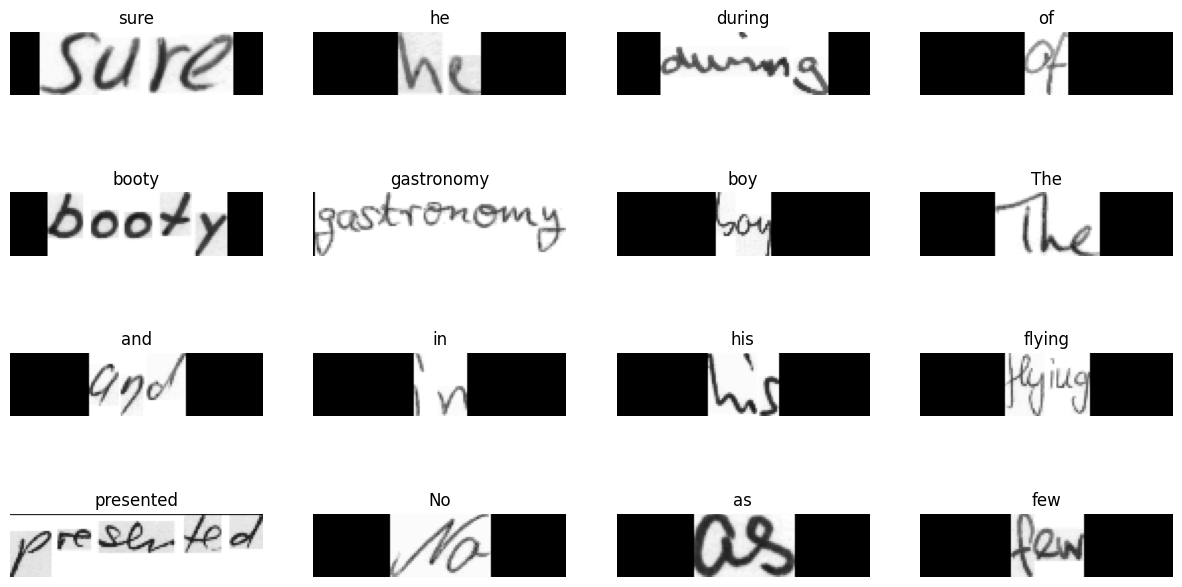

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

the content of the original image is kept as faithful as possible and has been padded accordingly

### Model

The model will use the CTC loss as an endpoint layer.

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost         #change to tf.keras.backend.ctc_batch_cost because keras.backend.ctc_batch_cost not in keras 3

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt,jit_compile=False)
    return model


# Get the model.
model = build_model()
model.summary()


Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 128, 32, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 32, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 16, 32)     │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 64, 16, 64)     │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 32, 8, 64)      │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 512)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 32, 64)         │         32,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 32, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 32, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 32, 81)         │         10,449 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 32, 81)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 424,081 (1.62 MB)

 Trainable params: 424,081 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

### Evaluation metric

Edit Distance is the most widely used metric for evaluating OCR models.
We will implement it and use it as a callback to monitor our model.

First we segregate the validation images and their labels for convenience.

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

Now, we create a callback to monitor the edit distances

In [ ]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.ops.nn.ctc_decode(predictions, sequence_lengths=input_len)[0][0][:, :max_len]  #changes to keras.backend.ctc_decode to keras.ops.nn.ctc_decode
    # predictions_decoded = keras.backend.ctc_decode(
    #     predictions, input_length=input_len, greedy=True
    # )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


In [ ]:
model.get_layer(name="image").output

<KerasTensor shape=(None, 128, 32, 1), dtype=float32, sparse=False, name=image>

In [ ]:
model.get_layer(name="dense2").output

<KerasTensor shape=(None, 32, 81), dtype=float32, sparse=False, name=keras_tensor_9>

### Training

In [ ]:
for layer in model.layers:
    print(layer.name)


image
Conv1
pool1
Conv2
pool2
reshape
dense1
dropout
bidirectional
bidirectional_1
label
dense2
ctc_loss


In [ ]:
epochs = 30  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").output, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72m

## Inference

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


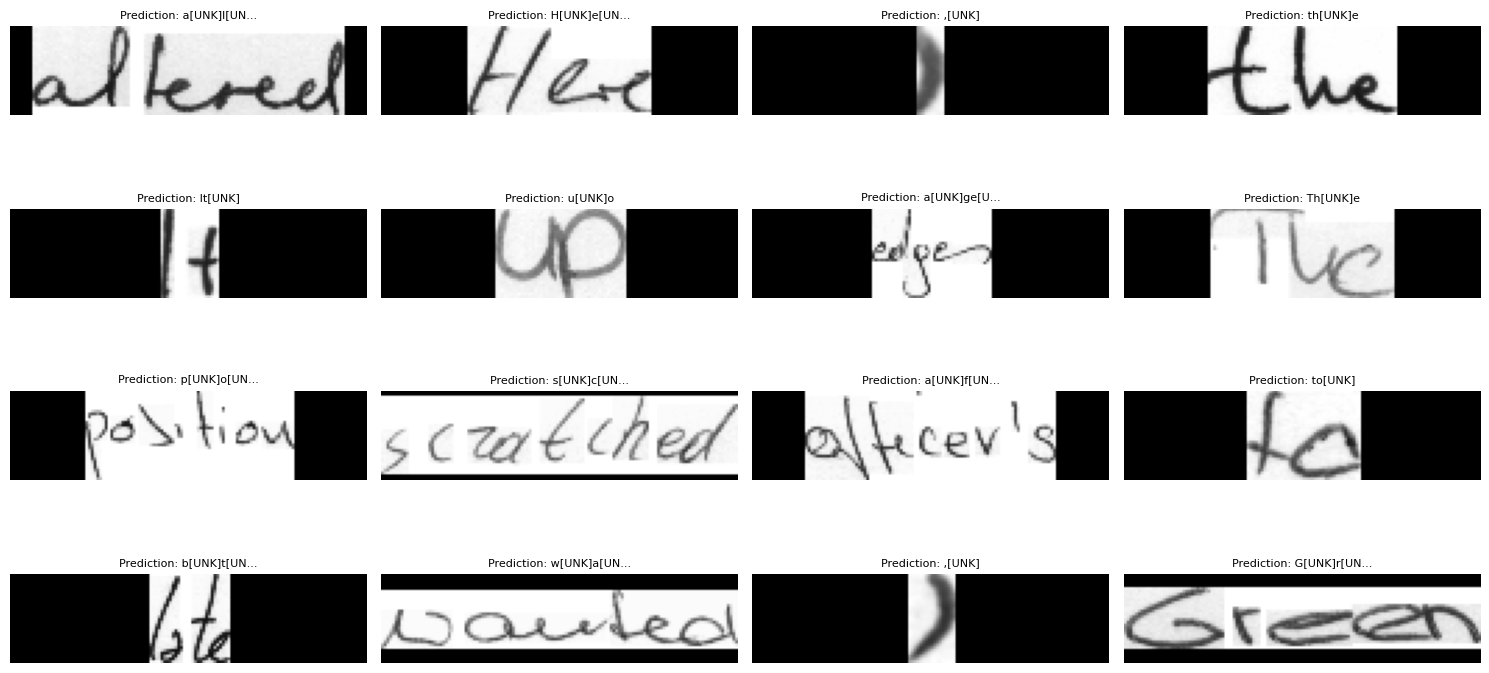

In [ ]:
# Required imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# Function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.ops.nn.ctc_decode(pred, sequence_lengths=input_len)[0][0][:, :max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Display results on some test samples
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Display the image
        ax[i // 4, i % 4].imshow(img, cmap="gray")

        # Adjust title to avoid overlapping
        title = f"Prediction: {pred_texts[i][:10]}..." if len(pred_texts[i]) > 10 else f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].set_title(title, fontsize=8)  # Adjust fontsize if needed
        ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()


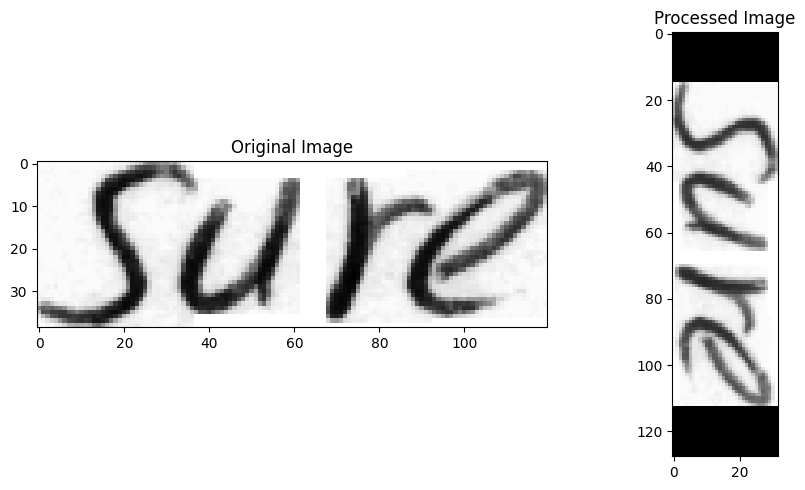

In [ ]:
img_path = train_img_paths[0]
original_image = tf.image.decode_png(tf.io.read_file(img_path), channels=1)
processed_image = preprocess_image(img_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image.numpy().squeeze(), cmap="gray")
axes[0].set_title("Original Image")
axes[1].imshow(processed_image.numpy().squeeze(), cmap="gray")
axes[1].set_title("Processed Image")
plt.tight_layout()
plt.show()


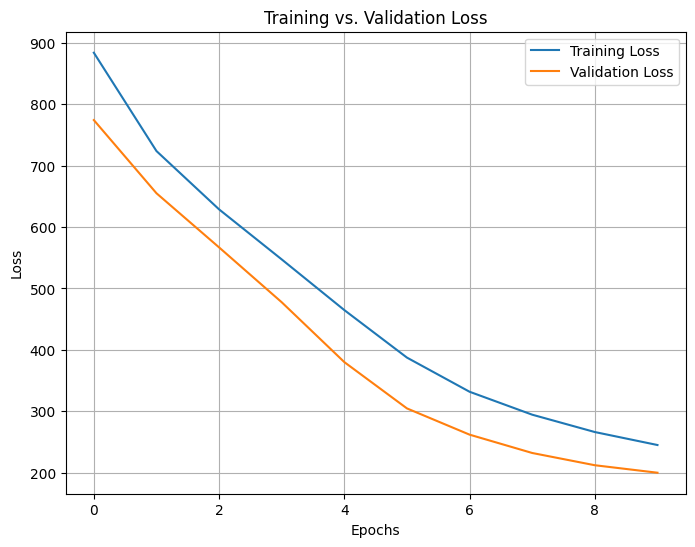

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


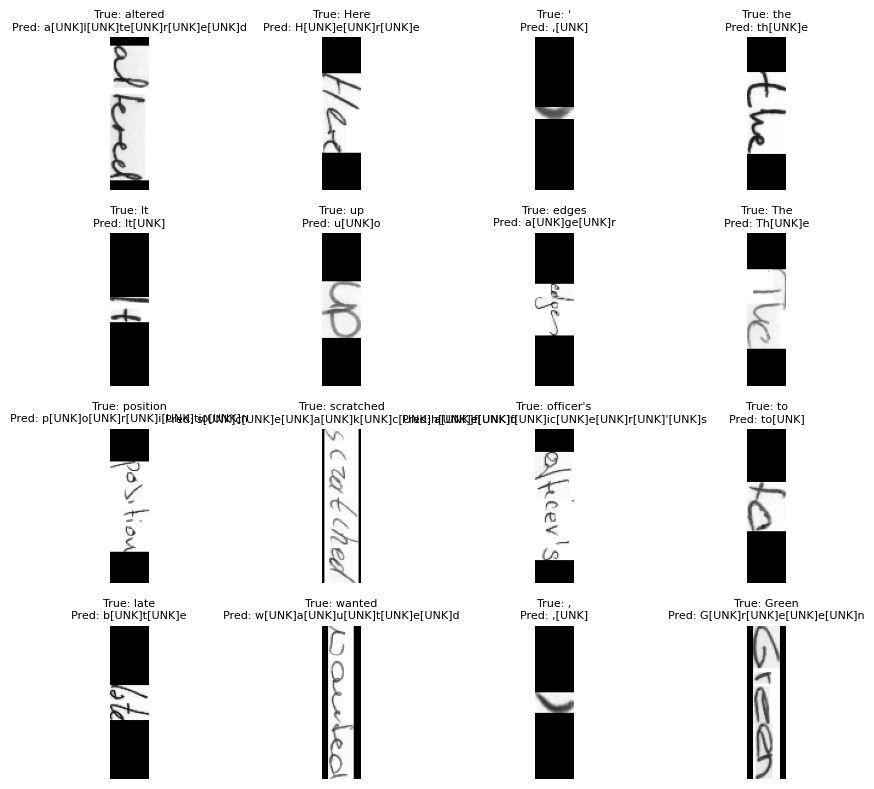

In [ ]:
# Assuming max_len is 32 (adjust as needed) based on the shape of preds
max_len = 32
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    # Pass num_to_char and max_len to decode_batch_predictions
    pred_texts = decode_batch_predictions(preds, num_to_char, max_len)

    _, ax = plt.subplots(4, 4, figsize=(10, 8))
    for i in range(16):
        img = batch_images[i]
        img = (img * 255.0).numpy().squeeze().astype(np.uint8)

        label = tf.strings.reduce_join(
            num_to_char(tf.gather(batch_labels[i], tf.where(batch_labels[i] != padding_token)))
        ).numpy().decode("utf-8")
        pred = pred_texts[i]

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(f"True: {label}\nPred: {pred}", fontsize=8)
        ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()


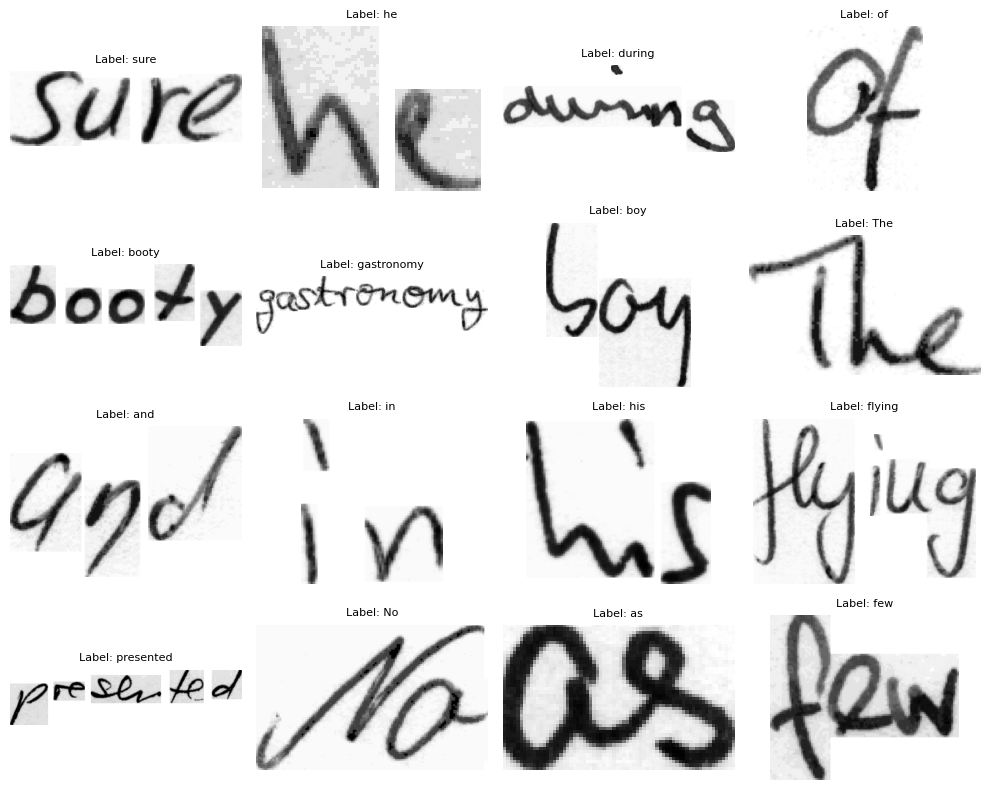

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 8))

for i in range(16):
    img_path = train_img_paths[i]
    label = train_labels_cleaned[i]
    img = plt.imread(img_path)

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(f"Label: {label}", fontsize=8)
    ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()


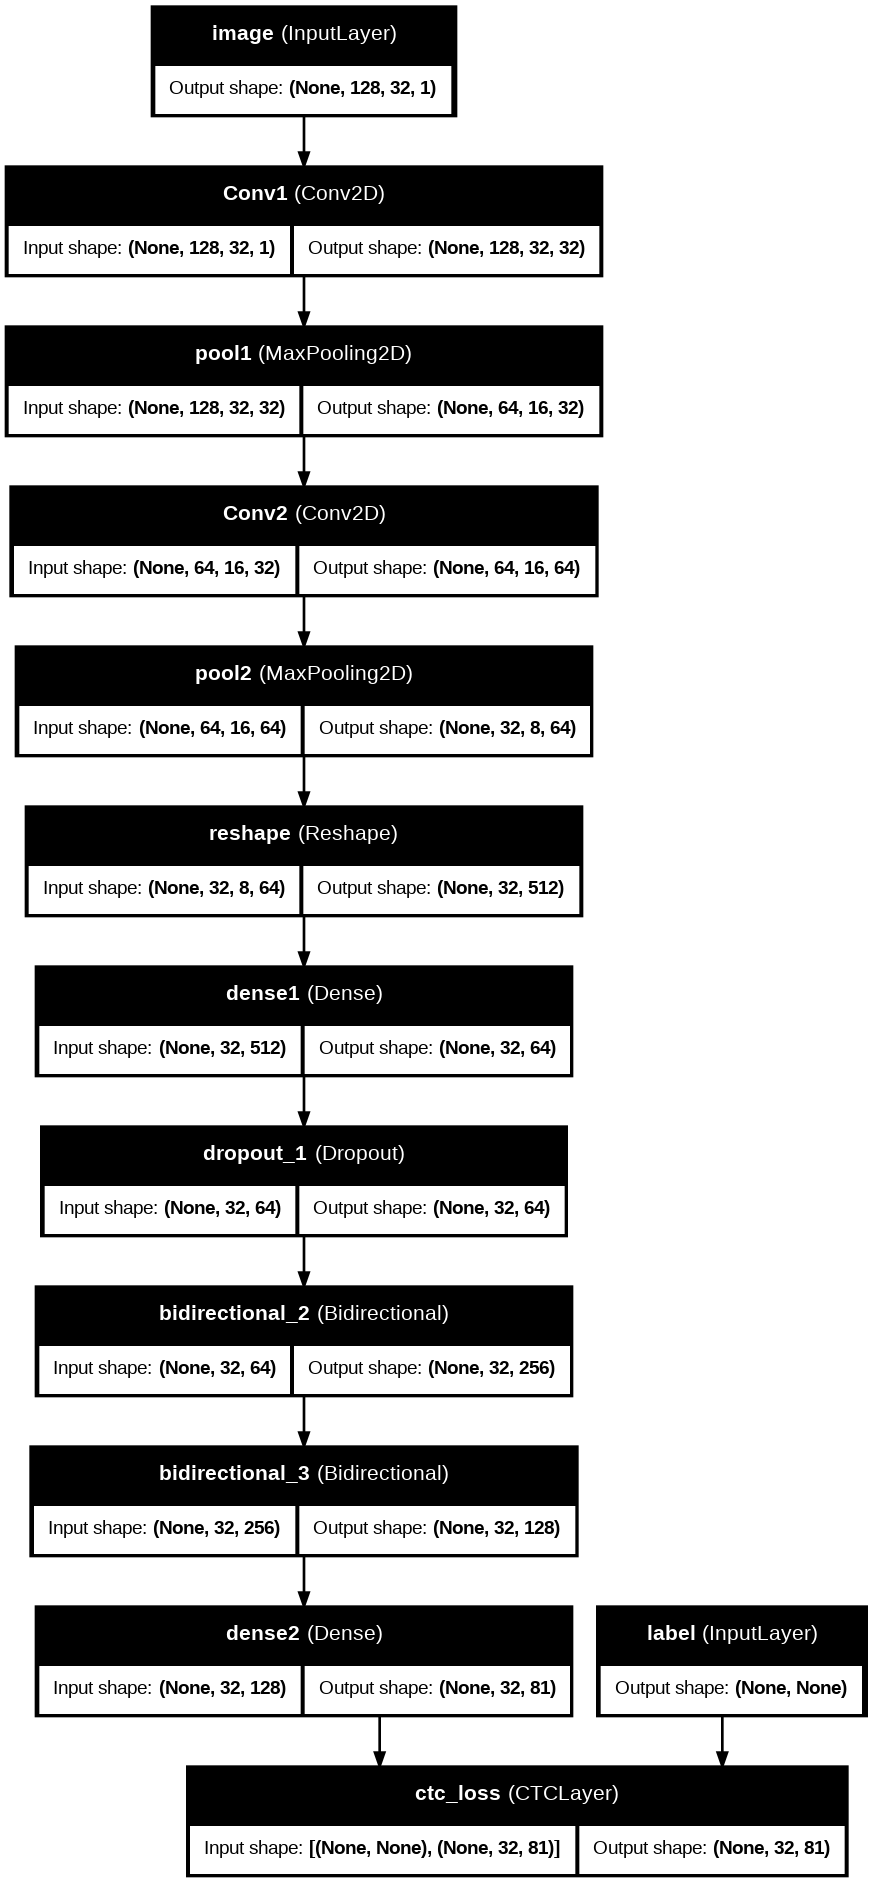

In [ ]:
#Export the Architecture as a Flowchart
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)


In [ ]:
model.save("handwriting_model.h5")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


<ipython-input-44-de08ce69cca8>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=characters, y=accuracy, palette="viridis")


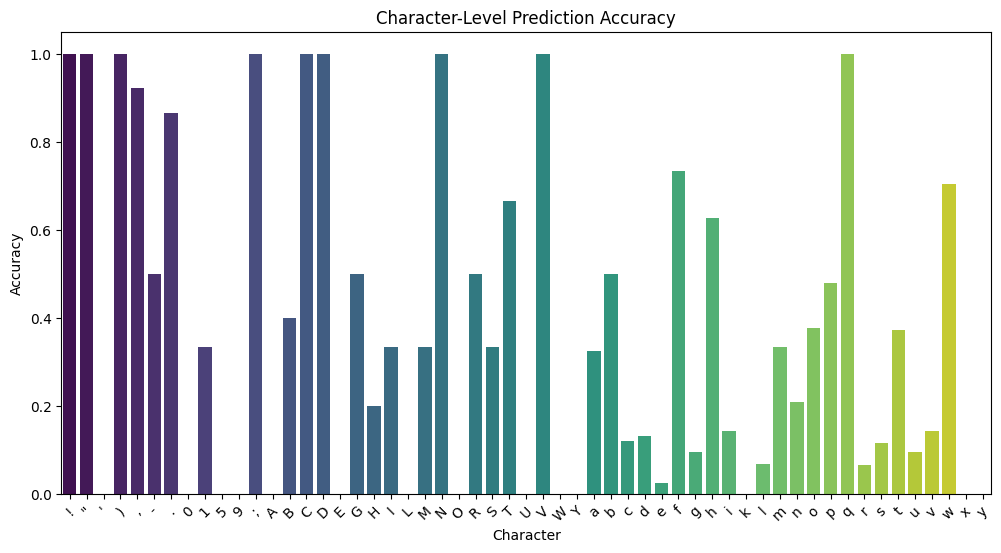

In [ ]:
import seaborn as sns
from collections import Counter

# Initialize counters
correct_counts = Counter()
total_counts = Counter()

# Iterate through test dataset
for batch in test_ds.take(5):  # Use a subset for efficiency
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    # Pass num_to_char and max_len to decode_batch_predictions
    # Assuming max_len is 32 based on the shape of preds in global variables
    pred_texts = decode_batch_predictions(preds, num_to_char, 32)

    for i in range(len(batch_labels)):
        true_label = tf.strings.reduce_join(
            num_to_char(tf.gather(batch_labels[i], tf.where(batch_labels[i] != padding_token)))
        ).numpy().decode("utf-8")
        predicted_label = pred_texts[i]

        for t_char, p_char in zip(true_label, predicted_label):
            total_counts[t_char] += 1
            if t_char == p_char:
                correct_counts[t_char] += 1

# Calculate accuracy per character
characters = sorted(total_counts.keys())
accuracy = [correct_counts[char] / total_counts[char] for char in characters]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.barplot(x=characters, y=accuracy, palette="viridis")
plt.xlabel("Character")
plt.ylabel("Accuracy")
plt.title("Character-Level Prediction Accuracy")
plt.xticks(rotation=45)
plt.savefig("character_accuracy_heatmap.png")  # Save for PPT
plt.show()

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repository
%cd yolov5
!pip install -r requirements.txt  # Install required libraries


Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 22.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"scarletbrown","key":"e4b33dcf15b875b5af0592335f60d8b2"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ipythonx/totaltextstr


Dataset URL: https://www.kaggle.com/datasets/ipythonx/totaltextstr
License(s): copyright-authors
 98% 485M/494M [00:02<00:00, 213MB/s]
100% 494M/494M [00:02<00:00, 202MB/s]
